# Lego Analysis

Author: M. Tosic

Date: 01.2022

This notebook is part of my capstone project for a data science course. The project is independent and has no connection to the company LEGO.

# 1. Business Understanding

### Questions of interest

**A) Exploratory Analysis**
* **What themes are most dominant over the years?**
* **What sets where record breakers in terms of piece count?**
* **What sets where record breakers in terms of number of minifigs?**
* **What words do most often come up in set names?**
* Are lego sets becomming more and more expensive?
* Retail price to piece count?
* Does the value of sets go up after eol on average?
* What sets do best after eol? (eol = lego-term for end-of-life meaning the date when the set is not being produced 

**B) Predictive Analysis**
* What are features of the data set are good predictors that will rise in value after eol?
* What do the words contained in the set names tell us about the rise of value after eol.
* What sets that are currently being sold can I predicte to be a good investment after eol?* 

*e.g. price increase of at least 10 usd (for package and shipment when selling) + at least 25% profit

# 2. Data Understanding

Data being used in this notebook has been downloaded from the following sources:

* https://brickset.com/
* https://rebrickable.com/downloads/

Simplifications:
* No time series data on the price averages available. Assumption: price changes average out over time after eol. The price curves are already in a steady state.
* No data available on unique minifigs in sets (minifig are popular for collectors that focus on them and are generally believed to drive up the prices of some sets after eol).

### Import Libraries

In [472]:
import numpy as np
import pandas as pd

#cisualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100) #pd.set_option('display.max_rows', None)

# import necessary libraries for batch import csv:
import os
import glob

#for counting elements in a list:
from collections import Counter

#needed for text processing:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

### Import Data

In [473]:
df_sets = pd.read_csv('data/rebrickable-sets.csv')
df_themes = pd.read_csv('data/rebrickable-themes.csv')

In [641]:
def import_multiple_csv_files_2_df (relative_path):
    """ Function uses os and glob packages to import multiple csv files into one dataframe. 
    The current working directory should be the one where this notebook is located.
    INPUT: 
    Relative path to the files e.g. "./data/Kurac*.csv"
    OUTPUT: 
    One dataframe containting all csv files concatenated together over axis = 0.
    """
    path = os.getcwd()
    files = glob.glob(os.path.join(path, relative_path))
    
    print('Glob search with parameters:', relative_path)
   # print('Ingested files:')
    li = []
    for file in files:
        df_temp = pd.read_csv(file, index_col = None, header = 0)
        li.append(df_temp)
        #print(file)
    try:    
        df = pd.concat(li, axis=0, ignore_index=True)
        print('Done.')

    except:
        print('Something went wrong the concatenation of the files, returning None. Is the relative_path correctly set?')
        return(None)
    
    return (df)

In [1030]:
df = import_multiple_csv_files_2_df("./data/Brickset*.csv")

Glob search with parameters: ./data/Brickset*.csv
Done.


**Droping unnessecary columns:**

In [1031]:
df.drop(['Qty owned','UPC','Qty owned new', 
         'Qty owned used', 'EAN','Priority','Wanted', 'Height', 'Depth', 'Weight', 'Width', 
         'Notes','Qty wanted','RRP (CAD)','Flag 1 not used', 'Flag 2 not used', 'Flag 3 not used',
         'Flag 4 not used', 'Flag 5 not used', 'Flag 6 not used','Flag 7 not used', 'Flag 8 not used'], axis=1, inplace=True)

**Adapting columns names to be able to user dot notation and more intuitive code(e.g. price instead of rrp):**

In [1032]:
df.rename(columns = lambda x : x.replace(' ', '_').replace('(','').replace(')','').lower().strip(), inplace = True)
df.columns

Index(['number', 'theme', 'subtheme', 'year', 'set_name', 'minifigs', 'pieces',
       'rrp_gbp', 'rrp_usd', 'rrp_eur', 'value_new_usd', 'value_used_usd',
       'launch_date', 'exit_date'],
      dtype='object')

In [1036]:
df.rename(columns={'rrp_usd': 'price', 'value_new_usd': 'value_new', 'value_used_usd':'value_used'}, inplace = True)
df.columns

In [1038]:
df.sort_values(["year","launch_date"], inplace = True)

In [1026]:
#Parse dates
#df['launch_date'] = pd.to_datetime(df['launch_date'])
#df['exit_date'] = pd.to_datetime(df['exit_date'])

In [1039]:
df.head()

,number,theme,subtheme,year,set_name,minifigs,pieces,rrp_gbp,price,rrp_eur,value_new,value_used,launch_date,exit_date
0,819-1,Basic,Supplementaries,1991,Blue baseplate,NaN,1.00,NaN,5.50,NaN,6.26,NaN,NaN,NaN
1,1040-1,Dacta,NaN,1991,Farm,4.00,89.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1474-1,Basic,Universal Building Set,1991,Basic Building Set with Gift Item,1.00,69.00,NaN,NaN,NaN,24.64,NaN,NaN,NaN
3,1475-1,Town,Flight,1991,Airport Security Squad,2.00,123.00,NaN,10.00,NaN,165.90,49.80,NaN,NaN
4,1476-1,Assorted,Bonus/Value Pack,1991,Five Set Bonus Pack,NaN,158.00,NaN,NaN,NaN,450.00,100.00,NaN,NaN


### Exploring Content

**Checking types per column:**

In [671]:
 df.describe()

,year,minifigs,pieces,rrp_gbp,rrp_usd,rrp_eur,value_new_usd,value_used_usd
count,"11,668.00","6,881.00","11,548.00","6,619.00","8,294.00","3,126.00","10,206.00","8,659.00"
mean,"2,009.65",2.69,235.08,29.53,32.49,43.92,72.75,40.17
std,8.40,2.81,465.41,42.58,47.82,60.97,159.79,73.63
min,"1,991.00",1.00,0.00,0.00,0.00,0.01,0.00,0.25
25%,"2,003.00",1.00,25.00,7.99,7.00,9.99,10.99,6.50
50%,"2,012.00",2.00,77.00,17.59,19.99,24.99,28.56,16.09
75%,"2,017.00",3.00,257.00,34.99,39.99,49.99,72.80,42.40
max,"2,021.00",33.00,"11,695.00",699.99,799.99,799.99,"5,197.53","1,391.39"


In [672]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11668 entries, 0 to 15622
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   number            11668 non-null  object 
 1   theme             11668 non-null  object 
 2   subtheme          8840 non-null   object 
 3   year              11668 non-null  int64  
 4   set_name          11668 non-null  object 
 5   minifigs          6881 non-null   float64
 6   pieces            11548 non-null  float64
 7   rrp_gbp           6619 non-null   float64
 8   rrp_usd           8294 non-null   float64
 9   rrp_eur           3126 non-null   float64
 10  value_new_usd     10206 non-null  float64
 11  value_used_usd    8659 non-null   float64
 12  launch_date       6485 non-null   object 
 13  exit_date         6485 non-null   object 
 14  numeric_data_nan  11668 non-null  bool   
 15  category          11668 non-null  object 
dtypes: bool(1), float64(7), int64(1), object

**Check if there are duplicated values:**

In [673]:
df[df.duplicated()]

,number,theme,subtheme,year,set_name,minifigs,pieces,rrp_gbp,rrp_usd,rrp_eur,value_new_usd,value_used_usd,launch_date,exit_date,numeric_data_nan,category


**Unique values per column:**

In [674]:
df.nunique().sort_values(ascending = True)

numeric_data_nan        1
category                2
year                   31
minifigs               31
rrp_eur               125
theme                 141
exit_date             165
rrp_gbp               248
rrp_usd               303
launch_date           404
subtheme              599
pieces               1312
value_used_usd       4484
value_new_usd        6013
set_name             9849
number              11668
dtype: int64

**Investigate missing values in data set:**

In [675]:
print("Percentages of missing values:\n{}".format(df.isnull().sum()/df.shape[0]*100))

Percentages of missing values:
number              0.00
theme               0.00
subtheme           24.24
year                0.00
set_name            0.00
minifigs           41.03
pieces              1.03
rrp_gbp            43.27
rrp_usd            28.92
rrp_eur            73.21
value_new_usd      12.53
value_used_usd     25.79
launch_date        44.42
exit_date          44.42
numeric_data_nan    0.00
category            0.00
dtype: float64


In [676]:
df_missing_val_per = pd.DataFrame(df.isnull().sum()/df.shape[0]*100, columns=['value'])
df_missing_val_per_sorted = df_missing_val_per.sort_values(by = "value", ascending = False)

In [677]:
px.bar(df_missing_val_per_sorted, 
       x = df_missing_val_per_sorted.index, 
       y = "value", 
       labels = {"value":"percentage of missing values"})


**Comments:**
* There are NaN values in most columns.
* Most values are missing in rrp_eur, but this is ok since the analysis will be done in usd (due to value_new and value_used also being in usd). The available rrp_eur values can be used to fill-in missing data in the usd column.
* More than half of the items don't have a launch and exit date.
* The missing values for minifigs could just be due to the items being lego sets without any minifigures or those are other lego product merchendise.

**Tasks:**
* A quarter of the items are missing piece counts. This must be investigated since it could indicate the item is not a lego set but some other kind of merchandise from the database. I will aim to categorize the items into sets and other merchendise. A possible way to does this is to use the pieces count >0 or minifigure >0.

* Most prices are available in usd, also the value new and used is available in usd. If possible I will try to calculate missing values in usd by the columns of other currencies then drop the other columns to reduce complexity for further processing (one currency is enough for the inteded analysis).

* Also some dates are missing, I'll take a look at that. Sets from 2022 have probably not yet been released, I will label them as not released. The items that have a launch date but no exit date will be labeled as active, items that have an exit date will be label eol (popular lego term "end-of-life" for items that are no longer produced).

**Make box-plots of all columns with numerival values:**

In [1040]:
def make_plots_of_num_cols(df):
    for col in df.columns:
        if df[col].dtype == np.int64 or df[col].dtype == np.float64:
            print(col)
            fig = px.box(df, x = col, points="all")
            fig.update_yaxes(visible = False, showticklabels = False)
            fig.show()
        else:
            continue

In [1042]:
#make_plots_of_num_cols(df)

**Comments**
* Year: The median is 2012 meaning that half of the items in the data-set containing the past 30th years were released in the past 9 years.
* Minifing: Median is only 2. This should be investigated in more detail since data set includes lego items that are not necessarily sets but other merchandice.
* Pieces: Similare goes for the rather low median of pieces. 

**Task**
* Task categorize entries as sets very other merchandice.

In [679]:
px.scatter(df, x = "year", y = "theme", color = "theme")

## 3. Prepare Data

### Removing rows where there is no numeric data

In [682]:
cond = df[['minifigs','pieces',
       "rrp_gbp", "rrp_eur", "rrp_usd", 
       "value_new_usd", "value_used_usd", 
       "launch_date", "exit_date"]].isnull().values.all(axis=1)
df['numeric_data_nan'] = np.where(cond, True, False)
df[df["numeric_data_nan"] == True].head()

,number,theme,subtheme,year,set_name,minifigs,pieces,rrp_gbp,rrp_usd,rrp_eur,value_new_usd,value_used_usd,launch_date,exit_date,numeric_data_nan,category


In [683]:
df = df[df["numeric_data_nan"] == False]

In [684]:
df.head()

,number,theme,subtheme,year,set_name,minifigs,pieces,rrp_gbp,rrp_usd,rrp_eur,value_new_usd,value_used_usd,launch_date,exit_date,numeric_data_nan,category
0,819-1,Basic,Supplementaries,1991,Blue baseplate,NaN,1.00,NaN,5.50,NaN,6.26,NaN,NaN,NaN,False,set
1,1040-1,Dacta,NaN,1991,Farm,4.00,89.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,set
2,1474-1,Basic,Universal Building Set,1991,Basic Building Set with Gift Item,1.00,69.00,NaN,NaN,NaN,24.64,NaN,NaN,NaN,False,set
3,1475-1,Town,Flight,1991,Airport Security Squad,2.00,123.00,NaN,10.00,NaN,165.90,49.80,NaN,NaN,False,set
4,1476-1,Assorted,Bonus/Value Pack,1991,Five Set Bonus Pack,NaN,158.00,NaN,NaN,NaN,450.00,100.00,NaN,NaN,False,set


### Categorization of items to sets and minifigures while removing items such as gear, books, etc.

In [685]:
#Over our long history, we’ve made loads of unique sets, many with similar names. We use numbers as a quick and convenient way to instantly identify any LEGO set. Numbers on the first sets we made were three digits long, but as we made more and more sets, we started using longer numbers. Currently, set numbers are five to seven digits long and are featured prominently on the box and instructions for the set.

In [686]:
df.head(50)

,number,theme,subtheme,year,set_name,minifigs,pieces,rrp_gbp,rrp_usd,rrp_eur,value_new_usd,value_used_usd,launch_date,exit_date,numeric_data_nan,category
0,819-1,Basic,Supplementaries,1991,Blue baseplate,NaN,1.00,NaN,5.50,NaN,6.26,NaN,NaN,NaN,False,set
1,1040-1,Dacta,NaN,1991,Farm,4.00,89.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,set
2,1474-1,Basic,Universal Building Set,1991,Basic Building Set with Gift Item,1.00,69.00,NaN,NaN,NaN,24.64,NaN,NaN,NaN,False,set
3,1475-1,Town,Flight,1991,Airport Security Squad,2.00,123.00,NaN,10.00,NaN,165.90,49.80,NaN,NaN,False,set
4,1476-1,Assorted,Bonus/Value Pack,1991,Five Set Bonus Pack,NaN,158.00,NaN,NaN,NaN,450.00,100.00,NaN,NaN,False,set
5,1477-1,Town,Racing,1991,Red Race Car Number 3,1.00,39.00,NaN,NaN,NaN,71.38,5.24,NaN,NaN,False,set
6,1478-1,Space,M-Tron,1991,Mobile Satellite Up-Link,1.00,31.00,NaN,NaN,NaN,190.52,19.07,NaN,NaN,False,set
7,1479-1,Space,Blacktron 2,1991,Two-Pilot Craft,2.00,34.00,NaN,NaN,NaN,NaN,21.77,NaN,NaN,False,set
8,1480-1,Castle,Crusaders,1991,King's Catapult,1.00,33.00,NaN,NaN,NaN,NaN,15.90,NaN,NaN,False,set
9,1481-1,Pirates,NaN,1991,Pirates Desert Island,1.00,21.00,NaN,NaN,NaN,189.42,17.74,NaN,NaN,False,set


In [687]:
df[['number_main','number_sub']] = df['number'].str.split('-',expand=True)

In [688]:
df.number_main

0         819
1        1040
2        1474
3        1475
4        1476
         ... 
15618    9757
15619    9758
15620    9805
15621    9912
15622    9916
Name: number_main, Length: 11668, dtype: object

In [689]:
df.drop(df.index[df["number_main"].apply(lambda x: not (x.isnumeric()))], axis=0, inplace=True)

In [690]:
df.drop(df.index[df["number_sub"].apply(lambda x: not (x.isnumeric()))], axis=0, inplace=True)

In [691]:
df.drop(['number_main','number_sub'], axis = "columns", inplace = True)

**Adding category column with value set for all items with > 0 number of pieces:**

In [692]:
df['category'] = np.where(df['pieces'] > 0, "set", "uncategorized")
df[df.category == "uncategorized"].describe()

,year,minifigs,pieces,rrp_gbp,rrp_usd,rrp_eur,value_new_usd,value_used_usd
count,124.00,37.00,4.00,71.00,82.00,47.00,40.00,31.00
mean,"2,016.66",1.73,0.00,26.59,17.50,26.13,25.57,9.71
std,4.95,2.49,0.00,58.71,51.27,70.24,62.85,18.18
min,"1,997.00",1.00,0.00,1.99,1.99,2.99,3.53,3.15
25%,"2,013.75",1.00,0.00,2.49,3.99,3.99,6.00,4.00
50%,"2,018.00",1.00,0.00,3.49,4.99,3.99,7.18,4.67
75%,"2,021.00",1.00,0.00,3.49,4.99,3.99,10.98,5.47
max,"2,021.00",10.00,0.00,274.99,299.95,304.99,380.61,89.99


**Dealing with uncategorized items:**

In [693]:
uncat_themes = set(df[(df.category == "uncategorized")].theme)
print(uncat_themes)

{'Super Mario', 'Clikits', 'Sports', 'Technic', 'Education', 'Collectable Minifigures', 'Make and Create', 'Power Miners'}


In [694]:
for theme in uncat_themes:
    cond_2 = (df.theme == theme) & (df.category == "uncategorized")
    print("Theme:", theme)
    print("Number of rows:", df[cond_2].shape[0])
    display(df[cond_2])

Theme: Super Mario
Number of rows: 42


,number,theme,subtheme,year,set_name,minifigs,pieces,rrp_gbp,rrp_usd,rrp_eur,value_new_usd,value_used_usd,launch_date,exit_date,numeric_data_nan,category
1643,71386-0,Super Mario,Character Pack - Series 2,2021,Character Pack - Series 2 {Random bag},NaN,NaN,3.49,4.99,3.99,NaN,NaN,01/01/2021,31/07/2021,False,uncategorized
1644,71386-1,Super Mario,Character Pack - Series 2,2021,Huckit Crab,1.00,NaN,3.49,4.99,3.99,6.57,4.15,01/01/2021,31/07/2021,False,uncategorized
1645,71386-2,Super Mario,Character Pack - Series 2,2021,Spiny Cheep Cheep,1.00,NaN,3.49,4.99,3.99,6.46,3.88,01/01/2021,31/07/2021,False,uncategorized
1646,71386-3,Super Mario,Character Pack - Series 2,2021,Ninji,1.00,NaN,3.49,4.99,3.99,7.43,3.30,01/01/2021,31/07/2021,False,uncategorized
1647,71386-4,Super Mario,Character Pack - Series 2,2021,Foo,1.00,NaN,3.49,4.99,3.99,6.84,4.00,01/01/2021,31/07/2021,False,uncategorized
1648,71386-5,Super Mario,Character Pack - Series 2,2021,Parachute Goomba,1.00,NaN,3.49,4.99,3.99,6.60,3.15,01/01/2021,31/07/2021,False,uncategorized
1649,71386-6,Super Mario,Character Pack - Series 2,2021,Para-Beetle,1.00,NaN,3.49,4.99,3.99,5.91,4.20,01/01/2021,31/07/2021,False,uncategorized
1650,71386-7,Super Mario,Character Pack - Series 2,2021,Poison Mushroom,1.00,NaN,3.49,4.99,3.99,6.30,4.98,01/01/2021,31/07/2021,False,uncategorized
1651,71386-8,Super Mario,Character Pack - Series 2,2021,Thwimp,1.00,NaN,3.49,4.99,3.99,7.10,3.83,01/01/2021,31/07/2021,False,uncategorized
1652,71386-9,Super Mario,Character Pack - Series 2,2021,Fly Guy,1.00,NaN,3.49,4.99,3.99,6.35,4.50,01/01/2021,31/07/2021,False,uncategorized


Theme: Clikits
Number of rows: 1


,number,theme,subtheme,year,set_name,minifigs,pieces,rrp_gbp,rrp_usd,rrp_eur,value_new_usd,value_used_usd,launch_date,exit_date,numeric_data_nan,category
14672,7575-1,Clikits,Seasonal,2004,Clikits Advent Calendar,NaN,NaN,11.99,15.00,NaN,18.75,NaN,01/10/2004,31/12/2006,False,uncategorized


Theme: Sports
Number of rows: 1


,number,theme,subtheme,year,set_name,minifigs,pieces,rrp_gbp,rrp_usd,rrp_eur,value_new_usd,value_used_usd,launch_date,exit_date,numeric_data_nan,category
5896,3406-2,Sports,Football,2000,French Team Bus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/04/2000,30/06/2002,False,uncategorized


Theme: Technic
Number of rows: 1


,number,theme,subtheme,year,set_name,minifigs,pieces,rrp_gbp,rrp_usd,rrp_eur,value_new_usd,value_used_usd,launch_date,exit_date,numeric_data_nan,category
662,8299-1,Technic,NaN,1997,Search Sub,1.00,0.00,NaN,50.00,NaN,108.62,61.46,NaN,NaN,False,uncategorized


Theme: Education
Number of rows: 9


,number,theme,subtheme,year,set_name,minifigs,pieces,rrp_gbp,rrp_usd,rrp_eur,value_new_usd,value_used_usd,launch_date,exit_date,numeric_data_nan,category
1533,45345-1,Education,SPIKE Essential,2021,SPIKE Essential Set,NaN,NaN,274.99,274.95,304.99,380.61,NaN,NaN,NaN,False,uncategorized
1538,45609-1,Education,SPIKE Prime,2021,Small Hub,NaN,NaN,189.99,189.95,209.99,NaN,NaN,NaN,NaN,False,uncategorized
1541,45816-1,Education,FIRST LEGO League,2021,FIRST LEGO League Challenge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/08/2021,31/12/2023,False,uncategorized
1542,45817-1,Education,FIRST LEGO League,2021,Cargo Connect Explore Set,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/08/2021,31/12/2023,False,uncategorized
8378,45497-1,Education,Storage,2017,"Storage boxes, pack of 7",NaN,NaN,NaN,NaN,NaN,74.92,NaN,NaN,NaN,False,uncategorized
8379,45498-1,Education,NaN,2017,"Medium storage, 8 pack",NaN,NaN,NaN,NaN,NaN,111.49,NaN,NaN,NaN,False,uncategorized
9282,9412-1,Education,Duplo,2003,Duplo Bricks,NaN,NaN,28.99,NaN,NaN,NaN,NaN,NaN,NaN,False,uncategorized
12048,9310-1,Education,NaN,2007,Dinosaurs Set,NaN,NaN,NaN,NaN,NaN,NaN,89.99,NaN,NaN,False,uncategorized
12492,45080-1,Education,NaN,2013,Creative Cards,NaN,NaN,NaN,NaN,NaN,6.57,NaN,NaN,NaN,False,uncategorized


Theme: Collectable Minifigures
Number of rows: 66


,number,theme,subtheme,year,set_name,minifigs,pieces,rrp_gbp,rrp_usd,rrp_eur,value_new_usd,value_used_usd,launch_date,exit_date,numeric_data_nan,category
1588,66678-1,Collectable Minifigures,Marvel Studios,2021,LEGO Minifigures - Marvel Studios Series {Box ...,NaN,NaN,NaN,29.94,NaN,42.00,NaN,NaN,NaN,False,uncategorized
1592,71029-0,Collectable Minifigures,Series 21,2021,LEGO Minifigures - Series 21 {Random bag},NaN,NaN,3.49,4.99,3.99,NaN,NaN,01/01/2021,30/04/2021,False,uncategorized
1606,71029-14,Collectable Minifigures,Series 21,2021,LEGO Minifigures - Series 21 - Sealed Box,NaN,NaN,3.49,4.99,3.99,NaN,NaN,01/01/2021,30/04/2021,False,uncategorized
1607,71030-0,Collectable Minifigures,Looney Tunes,2021,LEGO Minifigures - Looney Tunes Series {Random...,NaN,NaN,3.49,4.99,3.99,NaN,NaN,26/04/2021,31/08/2021,False,uncategorized
1621,71030-14,Collectable Minifigures,Looney Tunes,2021,LEGO Minifigures - Looney Tunes Series - Seale...,NaN,NaN,3.49,4.99,3.99,NaN,NaN,26/04/2021,31/08/2021,False,uncategorized
1622,71031-0,Collectable Minifigures,Marvel Studios,2021,LEGO Minifigures - Marvel Studios Series {Rand...,NaN,NaN,3.49,4.99,3.99,NaN,NaN,01/09/2021,31/12/2021,False,uncategorized
1636,71031-14,Collectable Minifigures,Marvel Studios,2021,LEGO Minifigures - Marvel Studios Series - Sea...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/09/2021,31/12/2021,False,uncategorized
3429,71027-0,Collectable Minifigures,Series 20,2020,LEGO Minifigures - Series 20 {Random Bag},NaN,NaN,NaN,4.99,NaN,NaN,NaN,NaN,NaN,False,uncategorized
3448,71028-0,Collectable Minifigures,Harry Potter Series 2,2020,LEGO Minifigures - Harry Potter Series 2 {Rand...,NaN,NaN,NaN,4.99,NaN,NaN,NaN,NaN,NaN,False,uncategorized
3466,71028-18,Collectable Minifigures,Harry Potter Series 2,2020,LEGO Minifigures - Harry Potter Series 2 - Sea...,NaN,NaN,3.49,4.99,3.89,NaN,NaN,NaN,NaN,False,uncategorized


Theme: Make and Create
Number of rows: 1


,number,theme,subtheme,year,set_name,minifigs,pieces,rrp_gbp,rrp_usd,rrp_eur,value_new_usd,value_used_usd,launch_date,exit_date,numeric_data_nan,category
11514,7794-1,Make and Create,NaN,2006,{Set with two minifigs},NaN,NaN,19.99,NaN,NaN,NaN,NaN,NaN,NaN,False,uncategorized


Theme: Power Miners
Number of rows: 3


,number,theme,subtheme,year,set_name,minifigs,pieces,rrp_gbp,rrp_usd,rrp_eur,value_new_usd,value_used_usd,launch_date,exit_date,numeric_data_nan,category
2556,4559288-1,Power Miners,Promotional,2009,{Power Miners Promotional Polybag},1.00,NaN,NaN,NaN,NaN,29.50,NaN,NaN,NaN,False,uncategorized
2557,4559385-1,Power Miners,Promotional,2009,{Power Miners Promotional Polybag},1.00,NaN,NaN,NaN,NaN,14.63,NaN,NaN,NaN,False,uncategorized
2558,4559387-1,Power Miners,Promotional,2009,{Power Miners Promotional Polybag},1.00,NaN,NaN,NaN,NaN,9.26,NaN,NaN,NaN,False,uncategorized


**Dropping product collections, bundle, promotionals, sealed boxes, magazine gifts, shoes such as Adidas Original Superstar, etc. Other items that could be sorted as sets or minifigures are categorized.**


In [695]:
drop_col_list = ['Star Wars', 'DC Comics Super Heroes', 'City', 'The LEGO Movie 2', 
                     'Legends of Chima', 'Marvel Super Heroes',  'Books', 'Creator Expert', 
                       'Ninjago', 'Vidiyo', 'Disney', 'Miscellaneous', 'Gear', 'Duplo', 
                     'BrickHeadz', 'Promotional', 'Friends', 'Seasonal', 'Unikitty']
set_list = ["Clikits", 'Education','Make and Create', 'Sports']
minifig_list = ['Collectable Minifigures', 'Power Miners', 'Super Mario','Technic']
print("Rows that will be dropped:", drop_col_list)
print("To be categorized as sets:", set_list)
print("To be categorized as minifigs:", minifig_list)


Rows that will be dropped: ['Star Wars', 'DC Comics Super Heroes', 'City', 'The LEGO Movie 2', 'Legends of Chima', 'Marvel Super Heroes', 'Books', 'Creator Expert', 'Ninjago', 'Vidiyo', 'Disney', 'Miscellaneous', 'Gear', 'Duplo', 'BrickHeadz', 'Promotional', 'Friends', 'Seasonal', 'Unikitty']
To be categorized as sets: ['Clikits', 'Education', 'Make and Create', 'Sports']
To be categorized as minifigs: ['Collectable Minifigures', 'Power Miners', 'Super Mario', 'Technic']


In [696]:
for theme in set_list:
    df.loc[(df.theme == theme) & (df.category == "uncategorized"),'category'] ='set'

In [697]:
for theme in minifig_list:
    df.loc[(df.theme == theme) & (df.category == "uncategorized"),'category'] = "minifig"

In [698]:
df = df.drop(df[(df.category == "uncategorized") & (df.theme.isin(drop_col_list))].index)

In [699]:
df.category.unique()

array(['set', 'minifig'], dtype=object)

**Categorize Collectable Minifigures as minifigs.**


In [783]:
df.loc[(df.theme == "Collectable Minifigures"), "category"] = "minifig"

In [784]:
set(df[df.theme == "Collectable Minifigures"].category)

{'minifig'}

**Since 2022 is incomplete we sill save the rows from 2022 in a new dataframe and remove it from the main one.**


In [785]:
df_2022 = df[df.year == 2022]

In [1044]:
df = df[df.year != 2022]
print(set(df.year))

{1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021}


### Further preparation steps for exploration analysis

# Fill in missing prices here!!

### Further preparation steps for predictive analysis

In [788]:
df.category

0        set
1        set
2        set
3        set
4        set
        ... 
15618    set
15619    set
15620    set
15621    set
15622    set
Name: category, Length: 11668, dtype: object

## 4. Analysis

### A) Exporatory Analysis
#### What themes are most dominant over the years by number of sets?


In [789]:
df_sets = df[df.category == "set"]

In [791]:
df_temp = df_sets.groupby(by = ["year","theme"]).count().sort_values(by =["year", "number"], ascending = (True, False))
df_1 = pd.DataFrame(df_temp["number"])
df_1.reset_index();

In [792]:
df_2 = df_1.groupby(by = ["year"]).head(5).reset_index()
df_2.head(11)

,year,theme,number
0,1991,Duplo,36
1,1991,Service Packs,22
2,1991,Town,22
3,1991,Space,13
4,1991,Trains,12
5,1992,Town,27
6,1992,Duplo,17
7,1992,Basic,13
8,1992,Service Packs,12
9,1992,Castle,9


In [793]:
fig = px.bar(df_2, x="year", y="number", 
             color = "theme", title = "Top five themes by number of sets",
             labels = {"number":"sets"})
fig.update_layout(xaxis = dict(tickmode = 'linear',tick0 = 1,dtick = 2))
fig.show()

#### What sets where record breakers in terms of piece count?

In [812]:
def create_record_breaker_dataset(df, col):
    #Record-winner in 1991
    
    
    df_winner_1991 = df_sets[df_sets.year == 1991].sort_values(col, ascending = False).head(1)
    
    mask = df_sets[col].values >= df_winner_1991[col].values[0]
    df_winners = df_sets[mask].sort_values(by = ["year", "launch_date"])
    
    df_winners["cummulative"] = df_winners[col].cummax()
    df_winners.drop_duplicates(subset = "cummulative", inplace = True)
    df_winners.reset_index(drop = True, inplace = True)
    
    return df_winners

In [817]:
df_piece_count_winners = create_record_breaker_dataset(df_sets,"pieces")
df_piece_count_winners

,number,theme,subtheme,year,set_name,minifigs,pieces,rrp_gbp,rrp_usd,rrp_eur,value_new_usd,value_used_usd,launch_date,exit_date,numeric_data_nan,category,cummulative
0,9452-1,Dacta,NaN,1991,Giant LEGO topic set,NaN,"2,165.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,set,"2,165.00"
1,9287-1,Education,Town,1996,Bonus Lego Basic Town,11.00,"2,456.00",NaN,NaN,NaN,511.29,NaN,NaN,NaN,False,set,"2,456.00"
2,3450-1,Creator Expert,Sculptures,2000,Statue of Liberty,NaN,"2,882.00",NaN,199.00,NaN,200.00,793.69,15/11/2000,31/12/2002,False,set,"2,882.00"
3,10030-1,Star Wars,Ultimate Collector Series,2002,Imperial Star Destroyer,NaN,"3,096.00",249.99,269.99,NaN,"1,471.58",535.00,06/12/2002,31/12/2007,False,set,"3,096.00"
4,10143-1,Star Wars,Ultimate Collector Series,2005,Death Star II,NaN,"3,441.00",249.99,269.99,NaN,"2,449.00","1,206.66",01/09/2005,31/12/2007,False,set,"3,441.00"
5,10179-1,Star Wars,Ultimate Collector Series,2007,Ultimate Collector's Millennium Falcon,5.00,"5,197.00",342.49,499.99,NaN,"2,396.91","1,030.79",01/10/2007,31/12/2009,False,set,"5,197.00"
6,10189-1,Creator Expert,Buildings,2008,Taj Mahal,NaN,"5,922.00",199.99,299.99,NaN,750.00,342.63,01/10/2008,31/12/2010,False,set,"5,922.00"
7,75192-1,Star Wars,Ultimate Collector Series,2017,Millennium Falcon,8.00,"7,541.00",699.99,799.99,799.99,734.32,677.01,01/10/2017,31/12/2023,False,set,"7,541.00"
8,10276-1,Creator Expert,Buildings,2020,Colosseum,NaN,"9,036.00",439.99,549.99,499.99,566.10,431.41,27/11/2020,31/12/2023,False,set,"9,036.00"
9,31203-1,Art,Miscellaneous,2021,World Map,NaN,"11,695.00",219.99,249.99,249.99,253.60,NaN,01/06/2021,31/12/2023,False,set,"11,695.00"


In [818]:
df_piece_count_winners["text"] = df_piece_count_winners["set_name"] +" "+ "(" + df_piece_count_winners["number"] +")"

In [906]:
def make_h_bar_chart(df, x, y, color, text, title):
    
    fig = px.bar(df, 
             x=x, y=y, 
             color = color, orientation='h', text = text,  
             title = title,labels = {"index":"year"})
    fig.update_layout(yaxis = dict(tickmode = 'array',tickvals = df.index, ticktext = list(df.year) ))
    fig.update_layout(xaxis = dict(tickmode = 'linear',tick0 = 0,dtick = 1000))
    fig.update_traces(textfont_size=12, textangle=0, textposition="inside")#, cliponaxis=True)
    #fig.show()
    return fig

In [824]:
make_h_bar_chart(df_piece_count_winners, "pieces", df_piece_count_winners.index, "theme",
                 "text", "Record breaking sets by piece count")

#### What sets where record breakers in terms of piece count?


In [821]:
df_minifig_winners = create_record_breaker_dataset(df_sets,"minifigs")
df_minifig_winners

,number,theme,subtheme,year,set_name,minifigs,pieces,rrp_gbp,rrp_usd,rrp_eur,value_new_usd,value_used_usd,launch_date,exit_date,numeric_data_nan,category,cummulative
0,9361-1,Dacta,NaN,1991,People,24.00,36.00,NaN,NaN,NaN,150.00,NaN,NaN,NaN,False,set,24.00
1,9293-1,Dacta,NaN,1996,Community Workers,30.00,182.00,NaN,31.50,NaN,83.00,69.00,NaN,NaN,False,set,30.00
2,9247-1,Education,NaN,2005,Community Workers,31.00,202.00,36.99,49.99,NaN,138.20,46.34,NaN,NaN,False,set,31.00
3,852293-1,Gear,Board Games,2008,Castle Giant Chess Set,33.00,"2,292.00",136.99,199.99,NaN,NaN,NaN,NaN,NaN,False,set,33.00


In [826]:
make_h_bar_chart(df_minifig_winners, "minifigs", df_minifig_winners.index,
                 "theme", "set_name", 
                 "Record breaking sets by no of minifigures")

#### What words do most often come up in set names?

In [1017]:
def tokenize(text):
    """Function for text processing, in particular it replaces urls, tokenizes and lemmatizes the words in a given text.
    INPUT
    text: text to process as str
    OUTPUT:
    tokens: list of tokenized words"""
    
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")
 
    # normalize case and remove punctuation using regex
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text with the tokenizer
    tokens = word_tokenize(text)
    
    # lemmatize and remove stop words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words("english")]

    return tokens

In [1018]:
results_list = []
df_sets.set_name.apply(lambda x: results_list.extend(tokenize(x)));
results_list

['blue',
 'baseplate',
 'farm',
 'basic',
 'building',
 'set',
 'gift',
 'item',
 'airport',
 'security',
 'squad',
 'five',
 'set',
 'bonus',
 'pack',
 'red',
 'race',
 'car',
 'number',
 '3',
 'mobile',
 'satellite',
 'link',
 'two',
 'pilot',
 'craft',
 'king',
 'catapult',
 'pirate',
 'desert',
 'island',
 'sailor',
 'parrot',
 'stena',
 'line',
 'ferry',
 'duplo',
 'bucket',
 'police',
 'car',
 'red',
 'race',
 'car',
 'fire',
 'dispatch',
 'evacuation',
 'team',
 'brick',
 'vac',
 'building',
 'set',
 '5',
 'special',
 'offer',
 'basic',
 'building',
 'set',
 '3',
 'special',
 'offer',
 'small',
 'bucket',
 'play',
 'bucket',
 'brick',
 '3',
 'large',
 'play',
 'bucket',
 '3',
 'pre',
 'school',
 'building',
 'set',
 'xl',
 'santa',
 'claus',
 'snowman',
 'santa',
 'elf',
 'red',
 'green',
 'building',
 'plate',
 'large',
 'red',
 'building',
 'plate',
 'building',
 'set',
 'building',
 'set',
 'pull',
 'back',
 'motor',
 'barney',
 'skateboard',
 'bear',
 'peter',
 'holiday',
 '

In [1019]:
results_count = Counter(results_list)
df_results_count = pd.DataFrame.from_dict(results_count, orient='index', columns = ["col"]).reset_index()
df_results_count.rename(columns = {'index':"word", "col":"occurances"}, inplace = True)
df_results_count.sort_values(by = "occurances", ascending = False, inplace = True)
df_results_count.reset_index(drop = True, inplace = True)
df_results_count.head(10)

,word,occurances
0,pack,572
1,set,496
2,brick,237
3,value,224
4,truck,208
5,bucket,186
6,lego,180
7,fire,176
8,bonus,175
9,1,167


In [1020]:
px.bar(df_results_count.head(25), "word", "occurances",
       color = "word", 
       title = "Top 25 most frequent words in set names")

### Questions of interest

**A) Exploratory Analysis**
* **What themes are most dominant over the years?**
* **What sets where record breakers in terms of piece count?**
* **What sets where record breakers in terms of number of minifigs?**
* **What words do most often come up in set names?**
* Are lego sets becomming more and more expensive?
* Retail price to piece count?
* Does the value of sets go up after eol on average?
* What sets do best after eol? (eol = lego-term for end-of-life meaning the date when the set is not being produced 

**B) Predictive Analysis**
* What are features of the data set are good predictors that will rise in value after eol?
* What do the words contained in the set names tell us about the rise of value after eol.
* What sets that are currently being sold can I predicte to be a good investment after eol?* 

*e.g. price increase of at least 10 usd (for package and shipment when selling) + at least 25% profit

In [ ]:
#adding missing prices in usd from other columns
#add this to the preparation part

In [1022]:
df

,number,theme,subtheme,year,set_name,minifigs,pieces,rrp_gbp,rrp_usd,rrp_eur,value_new_usd,value_used_usd,launch_date,exit_date,numeric_data_nan,category
0,819-1,Basic,Supplementaries,1991,Blue baseplate,NaN,1.00,NaN,5.50,NaN,6.26,NaN,NaN,NaN,False,set
1,1040-1,Dacta,NaN,1991,Farm,4.00,89.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,set
2,1474-1,Basic,Universal Building Set,1991,Basic Building Set with Gift Item,1.00,69.00,NaN,NaN,NaN,24.64,NaN,NaN,NaN,False,set
3,1475-1,Town,Flight,1991,Airport Security Squad,2.00,123.00,NaN,10.00,NaN,165.90,49.80,NaN,NaN,False,set
4,1476-1,Assorted,Bonus/Value Pack,1991,Five Set Bonus Pack,NaN,158.00,NaN,NaN,NaN,450.00,100.00,NaN,NaN,False,set
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15618,9757-1,Mindstorms,1.0,1999,Touch Sensor,NaN,2.00,NaN,11.00,NaN,8.00,6.99,NaN,NaN,False,set
15619,9758-1,Mindstorms,1.0,1999,Light Sensor,NaN,1.00,NaN,19.75,NaN,3.56,1.09,NaN,NaN,False,set
15620,9805-1,Education,NaN,1999,Duplo Play Wall,NaN,4.00,NaN,159.75,NaN,NaN,NaN,NaN,NaN,False,set
15621,9912-1,Education,NaN,1999,Solar Cell,NaN,1.00,NaN,35.00,NaN,NaN,18.75,NaN,NaN,False,set


### B) Predictive Analysis

## 5. Evaluation

<AxesSubplot:>

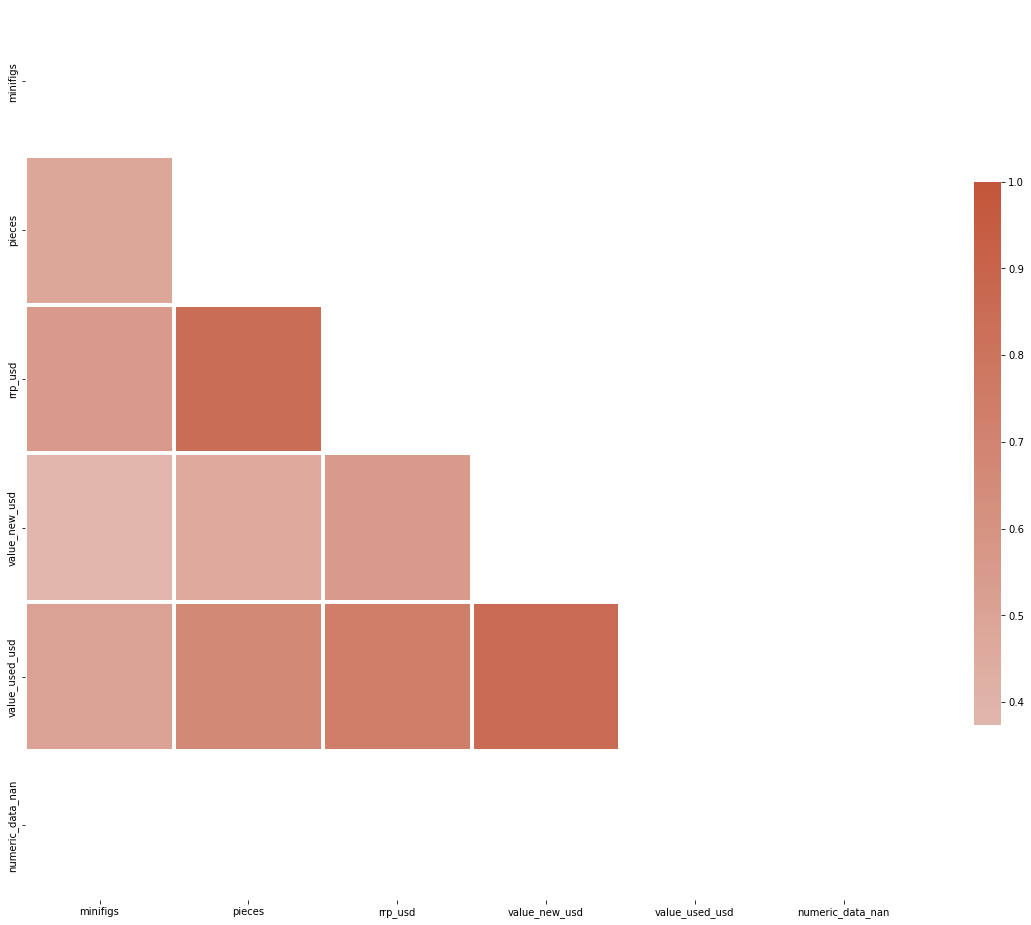

In [681]:
corr = df.drop(["year","rrp_gbp","rrp_eur"], axis = "columns").corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

f, ax = plt.subplots(figsize = (20,20))

cmap = sns.diverging_palette(200, 20, as_cmap = True)
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0, square = True, linewidth = 4, cbar_kws = {"shrink":.5})